In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import gc
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.model_selection import KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB

from lightgbm import LGBMRegressor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = stopwords.words('english')
import seaborn as sns
import string
import unidecode
import re
from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
%matplotlib inline

## EDA

In [24]:
train = pd.read_csv('Train.csv')

In [25]:
train.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [26]:
test = pd.read_csv('Test.csv')

In [27]:
test

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0
3,16870,we construct finite time blow-up solutions to ...,0,1,0,0
4,10496,planetary nebulae (pne) constitute an importan...,0,0,1,0
...,...,...,...,...,...,...
5997,11506,a first step inside constructing the machine l...,0,0,0,1
5998,3418,a focus of this paper was to quantify measures...,1,0,0,0
5999,7369,as autonomous vehicles become an every-day rea...,1,0,0,0
6000,8421,a hamiltonian monte carlo (hmc) method has bee...,0,0,0,1


In [28]:
ss = pd.read_csv('sample_sub.csv')

In [29]:
ss

,id,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,9409,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16071,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,11506,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5998,3418,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5999,7369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6000,8421,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
tags = pd.read_csv('Tags.csv')

In [31]:
tags.head()

,Tags
0,Analysis of PDEs
1,Applications
2,Artificial Intelligence
3,Astrophysics of Galaxies
4,Computation and Language


In [32]:
tags['Tags'].unique()

array(['Analysis of PDEs', 'Applications', 'Artificial Intelligence',
       'Astrophysics of Galaxies', 'Computation and Language',
       'Computer Vision and Pattern Recognition',
       'Cosmology and Nongalactic Astrophysics',
       'Data Structures and Algorithms', 'Differential Geometry',
       'Earth and Planetary Astrophysics', 'Fluid Dynamics',
       'Information Theory',
       'Instrumentation and Methods for Astrophysics', 'Machine Learning',
       'Materials Science', 'Methodology', 'Number Theory',
       'Optimization and Control', 'Representation Theory', 'Robotics',
       'Social and Information Networks', 'Statistics Theory',
       'Strongly Correlated Electrons', 'Superconductivity',
       'Systems and Control'], dtype=object)

In [36]:
test.columns

Index(['id', 'ABSTRACT', 'Computer Science', 'Mathematics', 'Physics',
       'Statistics'],
      dtype='object')

In [41]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications', 'Artificial Intelligence','Astrophysics of Galaxies', 'Computation and Language',
'Computer Vision and Pattern Recognition',
'Cosmology and Nongalactic Astrophysics',
'Data Structures and Algorithms', 'Differential Geometry',
'Earth and Planetary Astrophysics', 'Fluid Dynamics',
'Information Theory',
'Instrumentation and Methods for Astrophysics', 'Machine Learning',
'Materials Science', 'Methodology', 'Number Theory',
'Optimization and Control', 'Representation Theory', 'Robotics',
'Social and Information Networks', 'Statistics Theory',
'Strongly Correlated Electrons', 'Superconductivity',
'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics','Statistics']

In [42]:
len(TARGET_COLS)

25

In [44]:
train

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,8699,a methodology of automatic detection of a even...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14000,11912,we consider a case inside which the robot has ...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
14001,4842,despite being usually considered two competing...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
14002,12507,we present the framework and its implementatio...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
print(f"Shape of Train -> {train.shape}")
print(f"Shape of Test -> {train.shape}")
print(f"Number of topics -> {len(TARGET_COLS)}")

Shape of Train -> (14004, 31)
Shape of Test -> (14004, 31)
Number of topics -> 25


In [49]:
features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]

In [50]:
print(features)

['ABSTRACT', 'Computer Science', 'Mathematics', 'Physics', 'Statistics']


In [51]:
print(len(features))

5


### Distribution of topics

In [52]:
# Frequency of each tag in the dataset (to understand class imbalance)

In [54]:
# We count the number of 1s in each colummn and divide it with the total rows in the training data

In [53]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   id                                            14004 non-null  int64 
 1   ABSTRACT                                      14004 non-null  object
 2   Computer Science                              14004 non-null  int64 
 3   Mathematics                                   14004 non-null  int64 
 4   Physics                                       14004 non-null  int64 
 5   Statistics                                    14004 non-null  int64 
 6   Analysis of PDEs                              14004 non-null  int64 
 7   Applications                                  14004 non-null  int64 
 8   Artificial Intelligence                       14004 non-null  int64 
 9   Astrophysics of Galaxies                      14004 non-null  int64 
 10

In [62]:
# Finding if any columns have null values

In [63]:
train.isnull().sum()

id                                              0
ABSTRACT                                        0
Computer Science                                0
Mathematics                                     0
Physics                                         0
Statistics                                      0
Analysis of PDEs                                0
Applications                                    0
Artificial Intelligence                         0
Astrophysics of Galaxies                        0
Computation and Language                        0
Computer Vision and Pattern Recognition         0
Cosmology and Nongalactic Astrophysics          0
Data Structures and Algorithms                  0
Differential Geometry                           0
Earth and Planetary Astrophysics                0
Fluid Dynamics                                  0
Information Theory                              0
Instrumentation and Methods for Astrophysics    0
Machine Learning                                0


In [64]:
# Finding the number of unique values per column

In [65]:
train.nunique()

id                                              14004
ABSTRACT                                        14004
Computer Science                                    2
Mathematics                                         2
Physics                                             2
Statistics                                          2
Analysis of PDEs                                    2
Applications                                        2
Artificial Intelligence                             2
Astrophysics of Galaxies                            2
Computation and Language                            2
Computer Vision and Pattern Recognition             2
Cosmology and Nongalactic Astrophysics              2
Data Structures and Algorithms                      2
Differential Geometry                               2
Earth and Planetary Astrophysics                    2
Fluid Dynamics                                      2
Information Theory                                  2
Instrumentation and Methods 

In [70]:
train[TOPIC_COLS].sum()

Computer Science    5884
Mathematics         2831
Physics             3856
Statistics          3794
dtype: int64

### Word Clouds

In [73]:
from wordcloud import WordCloud, STOPWORDS

In [74]:
wc = WordCloud(stopwords = set(list(STOPWORDS) + ['inside']), random_state = 42)

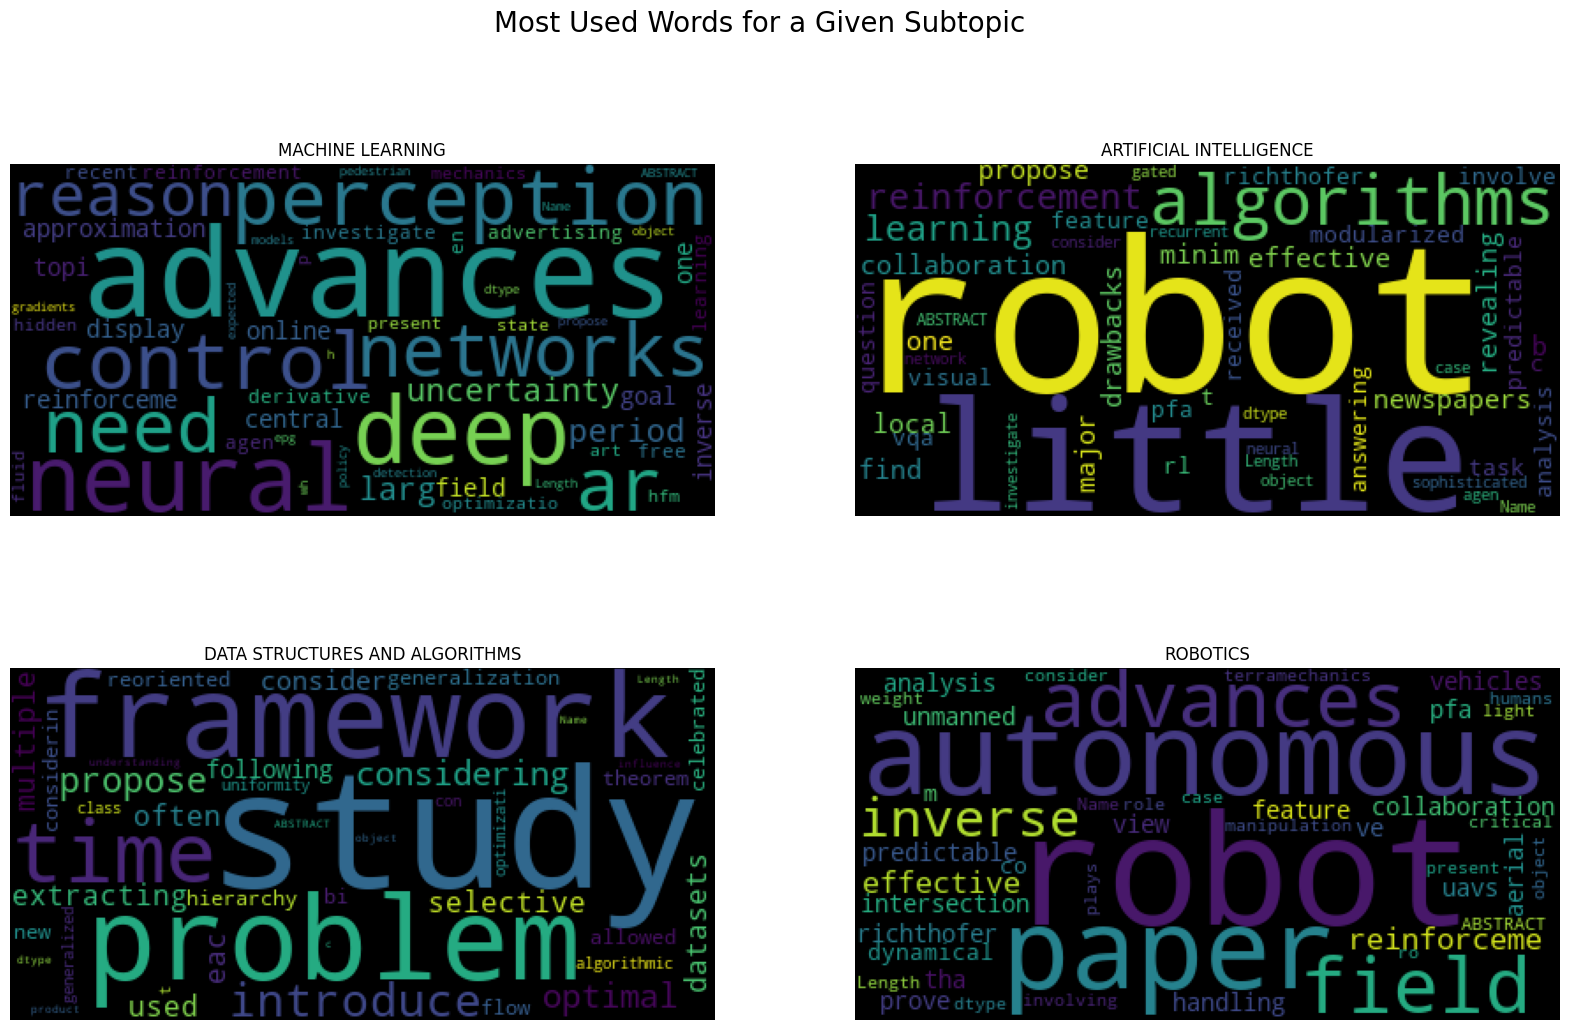

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(['Machine Learning', 'Artificial Intelligence', 'Data Structures and Algorithms', 'Robotics']):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=12)
  _ = axes[i].axis('off')
_ = plt.suptitle('Most Used Words for a Given Subtopic', fontsize=20)

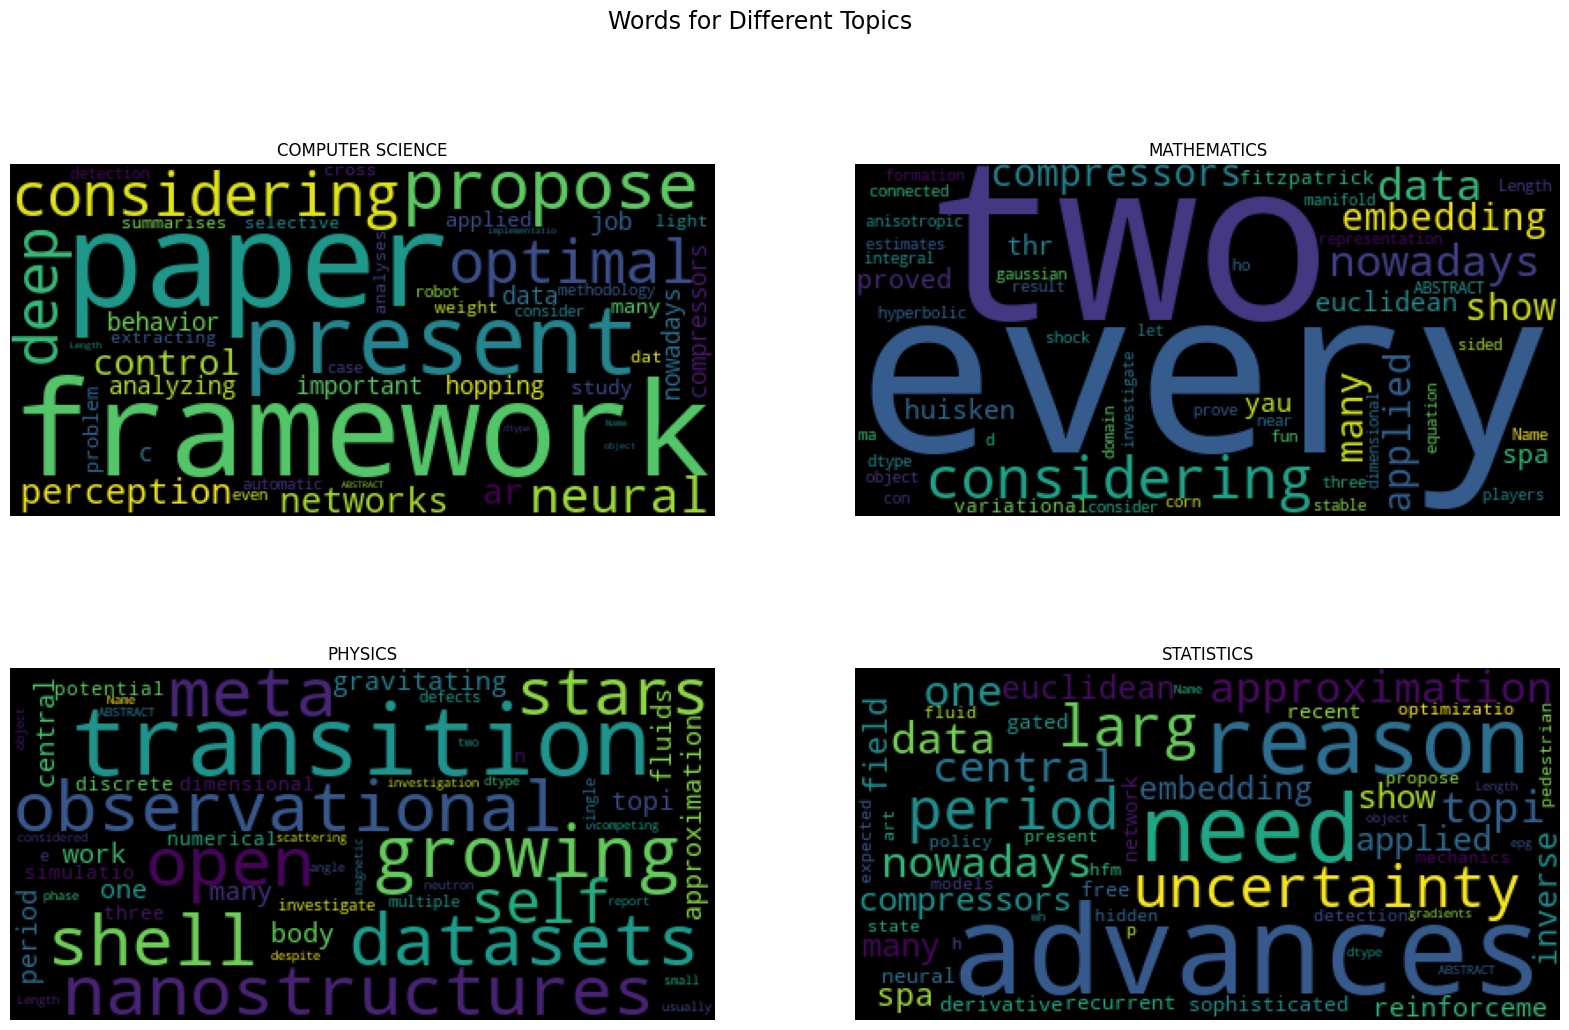

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(TOPIC_COLS):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=12)
  _ = axes[i].axis('off')
_ = plt.suptitle('Words for Different Topics', fontsize=17)

## Modeling

#### Bag of Words

In [91]:
sent1 = 'Recent advancements in AI include significant improvements in generative video and language model agents, particularly in benchmark performance and programming tasks.'
sent2 = 'Also, multimodal AI, which combines different data types, and explainable AI, which focuses on transparency, are gaining traction.'
sent3 = 'AI models are now capable of generating high-quality video content and, in some cases, outperforming humans in programming tasks.'

In [93]:
all_sentences = [sent1, sent2, sent3]
all_words = [w for sent in all_sentences for w in sent.split()]
all_words = list(set(all_words))

In [94]:
all_words

['advancements',
 'data',
 'outperforming',
 'and,',
 'different',
 'gaining',
 'cases,',
 'model',
 'AI',
 'transparency,',
 'AI,',
 'now',
 'some',
 'types,',
 'in',
 'which',
 'of',
 'language',
 'Also,',
 'models',
 'tasks.',
 'content',
 'multimodal',
 'Recent',
 'combines',
 'capable',
 'programming',
 'traction.',
 'video',
 'performance',
 'include',
 'are',
 'on',
 'generative',
 'particularly',
 'agents,',
 'explainable',
 'and',
 'focuses',
 'improvements',
 'benchmark',
 'significant',
 'humans',
 'generating',
 'high-quality']

In [99]:
columns = {word: [] for word in all_words}
for word in all_words:
    for sent in all_sentences:
        sent_words = sent.split()
        count = sum([(word == w) for w in sent_words])
        columns[word].append(count)

In [100]:
counts = pd.DataFrame(columns)

In [101]:
counts

,advancements,data,outperforming,"and,",different,gaining,"cases,",model,AI,"transparency,","AI,",now,some,"types,",in,which,of,language,"Also,",models,tasks.,content,multimodal,Recent,combines,capable,programming,traction.,video,performance,include,are,on,generative,particularly,"agents,",explainable,and,focuses,improvements,benchmark,significant,humans,generating,high-quality
0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,1,0,2,0,1,1,1,0,0,0
1,0,1,0,0,1,1,0,0,0,1,2,0,0,1,0,2,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0
2,0,0,1,1,0,0,1,0,1,0,0,1,1,0,2,0,1,0,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1


In [114]:
# Vectorizer by using bag of words

In [103]:
cvec = CountVectorizer(max_features=10000)

In [110]:
combined = list(train['ABSTRACT']) + list(test['ABSTRACT'])
cvec.fit(combined)

CountVectorizer(max_features=10000)

In [106]:
trn, val = train_test_split(train, test_size = 0.2, random_state = 1)

In [111]:
train_abs = cvec.transform(trn['ABSTRACT'])
test_abs = cvec.transform(test['ABSTRACT'])
val_abs = cvec.transform(val['ABSTRACT'])

In [112]:
trn[TARGET_COLS]

,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
13224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12777,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11482,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12172,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [115]:
trn

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
13224,970,real and complex clifford bundles and dirac op...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12777,15964,"inside partially observed environments, it sho...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3315,1489,a egalitarian processor sharing model was view...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1173,14311,we consider a challenging problem of statistic...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11482,19623,quantum computers should offer dramatic improv...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,13745,perivascular spaces (pvs) are the recently rec...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5192,11049,we start with a recently conjectured 3d bosoni...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12172,17687,gene expression data represents the unique cha...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
235,10009,with the help of combination of density functi...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [118]:
# Training the data

In [117]:
clssfr = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
clssfr.fit(train_abs, trn[TARGET_COLS])

OneVsRestClassifier(estimator=LogisticRegression(C=10, n_jobs=-1))

In [121]:
# Based on the trained data we are checking the 20% of the train dataset to check the accuracy.

In [119]:
clssfr_preds = clssfr.predict(val_abs)

In [120]:
clssfr_preds

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [122]:
f1_score(val[TARGET_COLS], clssfr_preds, average='micro')

0.6284816454792173

In [123]:
tst_pred = clssfr.predict(test_abs)

In [124]:
tst_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [125]:
def download_preds(tst_pred, file_name = 'hacklive_sub_BoW.csv'):

  # Setting the target column with our predictions
  ss[TARGET_COLS] = tst_pred

  ss.to_csv(file_name, index = False)

In [126]:
download_preds(tst_pred, 'hacklive_NLP_count.csv')

#### TF-IDF Vectorizer

In [127]:
sent1 = 'Recent advancements in AI include significant improvements in generative video and language model agents, particularly in benchmark performance and programming tasks.'
sent2 = 'Also, multimodal AI, which combines different data types, and explainable AI, which focuses on transparency, are gaining traction.'
sent3 = 'AI models are now capable of generating high-quality video content and, in some cases, outperforming humans in programming tasks.'

In [128]:
counts

,advancements,data,outperforming,"and,",different,gaining,"cases,",model,AI,"transparency,","AI,",now,some,"types,",in,which,of,language,"Also,",models,tasks.,content,multimodal,Recent,combines,capable,programming,traction.,video,performance,include,are,on,generative,particularly,"agents,",explainable,and,focuses,improvements,benchmark,significant,humans,generating,high-quality
0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,0,1,1,1,0,2,0,1,1,1,0,0,0
1,0,1,0,0,1,1,0,0,0,1,2,0,0,1,0,2,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0
2,0,0,1,1,0,0,1,0,1,0,0,1,1,0,2,0,1,0,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1


In [131]:
# Calculating term frequency per each sentence/document

In [129]:
term_frequency = counts.copy()
term_frequency = term_frequency.apply(lambda x: x/term_frequency.sum(axis = 1))

In [130]:
term_frequency

,advancements,data,outperforming,"and,",different,gaining,"cases,",model,AI,"transparency,","AI,",now,some,"types,",in,which,of,language,"Also,",models,tasks.,content,multimodal,Recent,combines,capable,programming,traction.,video,performance,include,are,on,generative,particularly,"agents,",explainable,and,focuses,improvements,benchmark,significant,humans,generating,high-quality
0,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.047619,0.047619,0.047619,0.000000,0.000000,0.047619,0.047619,0.047619,0.000000,0.095238,0.000000,0.047619,0.047619,0.047619,0.000000,0.000000,0.000000
1,0.000000,0.055556,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.000000,0.055556,0.111111,0.000000,0.000000,0.055556,0.000000,0.111111,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.055556,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.000000,0.055556,0.055556,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.052632,0.052632,0.000000,0.000000,0.052632,0.000000,0.052632,0.000000,0.000000,0.052632,0.052632,0.000000,0.105263,0.000000,0.052632,0.000000,0.000000,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.052632,0.052632,0.000000,0.052632,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.052632,0.052632


In [132]:
# Calculating Inverse Document Frequency (IDF) as log of number of sentences divided by the number of sentences containig that word

In [133]:
inverse_document_frequency = counts.copy()
inverse_document_frequency = inverse_document_frequency.apply(lambda x: 3/(x > 0).sum())

In [134]:
inverse_document_frequency

advancements     3.0
data             3.0
outperforming    3.0
and,             3.0
different        3.0
gaining          3.0
cases,           3.0
model            3.0
AI               1.5
transparency,    3.0
AI,              3.0
now              3.0
some             3.0
types,           3.0
in               1.5
which            3.0
of               3.0
language         3.0
Also,            3.0
models           3.0
tasks.           1.5
content          3.0
multimodal       3.0
Recent           3.0
combines         3.0
capable          3.0
programming      1.5
traction.        3.0
video            1.5
performance      3.0
include          3.0
are              1.5
on               3.0
generative       3.0
particularly     3.0
agents,          3.0
explainable      3.0
and              1.5
focuses          3.0
improvements     3.0
benchmark        3.0
significant      3.0
humans           3.0
generating       3.0
high-quality     3.0
dtype: float64

In [135]:
tfidf = term_frequency * inverse_document_frequency

In [136]:
tfidf

,advancements,data,outperforming,"and,",different,gaining,"cases,",model,AI,"transparency,","AI,",now,some,"types,",in,which,of,language,"Also,",models,tasks.,content,multimodal,Recent,combines,capable,programming,traction.,video,performance,include,are,on,generative,particularly,"agents,",explainable,and,focuses,improvements,benchmark,significant,humans,generating,high-quality
0,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.214286,0.000000,0.000000,0.142857,0.000000,0.000000,0.071429,0.000000,0.000000,0.142857,0.000000,0.000000,0.071429,0.000000,0.071429,0.142857,0.142857,0.000000,0.000000,0.142857,0.142857,0.142857,0.000000,0.142857,0.000000,0.142857,0.142857,0.142857,0.000000,0.000000,0.000000
1,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.166667,0.333333,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.083333,0.166667,0.000000,0.000000,0.000000,0.166667,0.083333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.157895,0.157895,0.000000,0.000000,0.157895,0.000000,0.078947,0.000000,0.000000,0.157895,0.157895,0.000000,0.157895,0.000000,0.157895,0.000000,0.000000,0.157895,0.078947,0.157895,0.000000,0.000000,0.000000,0.157895,0.078947,0.000000,0.078947,0.000000,0.000000,0.078947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.157895,0.157895


In [139]:
tfidfvec = TfidfVectorizer(max_features=10000)
_ = tfidfvec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))


In [140]:
trn_abs = tfidfvec.transform(trn['ABSTRACT'])
test_abs = tfidfvec.transform(test['ABSTRACT'])
val_abs = tfidfvec.transform(val['ABSTRACT'])

In [141]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn[TARGET_COLS])

In [147]:
pred_val = clf.predict(val_abs)
f1_score(val[TARGET_COLS], pred_val, average='micro')

0.6388050214524075

In [148]:
# For the test set (not the 20% from the training (val) but the actual test dataset)

In [151]:
test_pred = clf.predict(test_abs)
download_preds(test_pred, 'NLP_classification_tfidf.csv')